[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Piphi5/Adopt-a-Pixel3km-Notebooks/blob/main/Geospatial%20Enrichment/SSU%20Enrichment.ipynb)

# Setup

In [2]:
import os
import sys
import time
from collections import Counter

import ee
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from IPython.display import display
from matplotlib.lines import Line2D
from PIL import Image

from sklearn.metrics import (  # isort:skip
    ConfusionMatrixDisplay,
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
)

if "google.colab" in sys.modules:
    ee.Authenticate()
else:
    from selenium import webdriver
    from webdriver_manager.chrome import ChromeDriverManager

ee.Initialize()

files = [
    "grid_constants",
    "combine_csvs",
    "harmonization_vizualization_utils",
    "enrichment_utils",
]
if "google.colab" in sys.modules:
    for file in files:
        url = f"https://raw.githubusercontent.com/Piphi5/Adopt-a-Pixel3km-Notebooks/main/utils/code/{file}.py"
        exec(requests.get(url).text)
else:
    module_path = os.path.abspath(os.path.join("../utils/code"))
    sys.path.append(module_path)
    from combine_csvs import *
    from enrichment_utils import *
    from grid_constants import *
    from harmonization_vizualization_utils import *

# Get SSU Data

`ssu_path`: The path to the SSU CSV File

In [2]:
ssu_path = "SSU Data.csv"

In [3]:
ceo_df = pd.read_csv(ssu_path)
ceo_df

,Unnamed: 0,plotid,sampleid,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,sample_geom,Land Cover Elements
0,0,0,1,-89.568636,43.076502,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.076502197895906),bush/scrub
1,1,0,2,-89.568636,43.076574,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07657437629004),bush/scrub
2,2,0,3,-89.568636,43.076647,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.076646554599165),bush/scrub
3,3,0,4,-89.568636,43.076719,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07671873282328),bush/scrub
4,4,0,5,-89.568636,43.076791,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07679091096236),Trees_CanopyCover
...,...,...,...,...,...,...,...,...,...,...,...,...
223685,33294,9736,33295,-77.398765,38.898356,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.898356028195764),Building
223686,33296,9736,33297,-77.398765,38.898510,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.8985098352878),Impervious Surface (no building)
223687,33297,9736,33298,-77.398765,38.898587,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.8985867387089),grass
223688,33298,9736,33299,-77.398765,38.898664,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.89866364204673),grass


## Filter Data

In [4]:
valid_data = ceo_df[
    (~ceo_df["Land Cover Elements"].isna())
    & (
        (ceo_df["Land Cover Elements"] != "unknown")
        & (ceo_df["Land Cover Elements"] != "shadow")
    )
]

In [5]:
valid_data

,Unnamed: 0,plotid,sampleid,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,sample_geom,Land Cover Elements
0,0,0,1,-89.568636,43.076502,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.076502197895906),bush/scrub
1,1,0,2,-89.568636,43.076574,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07657437629004),bush/scrub
2,2,0,3,-89.568636,43.076647,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.076646554599165),bush/scrub
3,3,0,4,-89.568636,43.076719,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07671873282328),bush/scrub
4,4,0,5,-89.568636,43.076791,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07679091096236),Trees_CanopyCover
...,...,...,...,...,...,...,...,...,...,...,...,...
223685,33294,9736,33295,-77.398765,38.898356,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.898356028195764),Building
223686,33296,9736,33297,-77.398765,38.898510,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.8985098352878),Impervious Surface (no building)
223687,33297,9736,33298,-77.398765,38.898587,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.8985867387089),grass
223688,33298,9736,33299,-77.398765,38.898664,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.89866364204673),grass


## Harmonize with World Cover

In [6]:
def lookup_values(ceo_classification):
    return ceo_to_wc_lookup[ceo_classification]


wc_converter = np.vectorize(lookup_values)
valid_data["Land Cover Elements"] = wc_converter(
    valid_data["Land Cover Elements"].to_numpy()
)
valid_data

,Unnamed: 0,plotid,sampleid,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,sample_geom,Land Cover Elements
0,0,0,1,-89.568636,43.076502,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.076502197895906),Shrubland
1,1,0,2,-89.568636,43.076574,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07657437629004),Shrubland
2,2,0,3,-89.568636,43.076647,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.076646554599165),Shrubland
3,3,0,4,-89.568636,43.076719,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07671873282328),Shrubland
4,4,0,5,-89.568636,43.076791,52,False,2021-07-12 20:13,199.6 secs,Mapbox Satellite,POINT(-89.5686356660657 43.07679091096236),Trees
...,...,...,...,...,...,...,...,...,...,...,...,...
223685,33294,9736,33295,-77.398765,38.898356,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.898356028195764),Built-up
223686,33296,9736,33297,-77.398765,38.898510,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.8985098352878),Built-up
223687,33297,9736,33298,-77.398765,38.898587,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.8985867387089),Grassland
223688,33298,9736,33299,-77.398765,38.898664,41,False,2021-07-22 15:58,285.3 secs,Mapbox Satellite,POINT(-77.3987646339343 38.89866364204673),Grassland


# Preparing and downloading GEE Data

## Specify Parameters

- `ee_layer`: Specifies layer that will be used
- `increment`: Specifies the number of points per Earth Engine job so that the request doesn't time out

In [7]:
ee_layer = "ESA/WorldCover/v100"
increment = 5000

## Generate GEE Points

In [8]:
def to_gee(lat, lon, classification, plotid):
    return ee.Feature(
        ee.Geometry.Point([lon, lat]),
        {"classification": classification, "plotid": plotid},
    )


vectorized_gee = np.vectorize(to_gee)
ceo_features = vectorized_gee(
    valid_data["lat"].to_numpy(),
    valid_data["lon"].to_numpy(),
    valid_data["Land Cover Elements"].to_numpy(),
    valid_data["plotid"].to_numpy(),
).tolist()

## Make and send GEE jobs

In [9]:
dataset = ee.ImageCollection(ee_layer).first()

In [10]:
tasks = download_ee_points(dataset, ceo_features, increment, "CEO SSU WC Data", "CEOWC")

In [11]:
print_job_statuses(tasks)

{'COMPLETED': 27, 'RUNNING': 1, 'READY': 17}


# Combining GEE Data

## GEE Analysis Setup

GEE Data downloaded from Google Drive

`wc_directory`: The directory containing the Earth Engine Data that should have been downloaded to your drive

In [10]:
wc_directory = "SSU World Cover Data"

In [11]:
wc_df = get_csvs(wc_directory)
wc_df

,system:index,classification,median,plotid,.geo
0,0,Shrubland,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606..."
1,1,Shrubland,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606..."
2,2,Shrubland,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606..."
3,3,Shrubland,10.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606..."
4,4,Trees,10.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606..."
...,...,...,...,...,...
4965,4965,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202..."
4966,4966,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202..."
4967,4967,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202..."
4968,4968,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202..."


## Converting GEE Data to World Cover String

In [12]:
wc_df["WC_Class"] = worldcover_converter(wc_df["median"].to_numpy())

In [13]:
wc_df

,system:index,classification,median,plotid,.geo,WC_Class
0,0,Shrubland,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606...",Grassland
1,1,Shrubland,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606...",Grassland
2,2,Shrubland,30.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606...",Grassland
3,3,Shrubland,10.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606...",Trees
4,4,Trees,10.0,0,"{""type"":""Point"",""coordinates"":[-89.56863566606...",Trees
...,...,...,...,...,...,...
4965,4965,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202...",Grassland
4966,4966,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202...",Grassland
4967,4967,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202...",Grassland
4968,4968,Shrubland,30.0,2121,"{""type"":""Point"",""coordinates"":[-96.31751521202...",Grassland


## Align columns with CEO

In [14]:
wc_df.loc[wc_df["WC_Class"] == "Mangroves", "WC_Class"] = "Trees"

In [15]:
wc_df = wc_df.groupby("plotid").filter(lambda x: len(x) == 100)

In [16]:
labels = pd.unique(wc_df["WC_Class"])

# Generate Summary Statistics

## Confusion Matrix

### Raw Text Data

In [17]:
cm = confusion_matrix(wc_df["classification"], wc_df["WC_Class"], labels=labels)
cm

array([[14334,  4006,   824,  3749,  1623,   709,    41,    22,     0],
       [ 2246, 34154,    34,  2472,   666,  1532,   120,    46,     5],
       [ 1439,   311,  2623,   344,   208,     1,     0,     2,     0],
       [ 1785,  5134,    93, 23367,  3645,   349,   100,    14,     0],
       [ 3825,   812,   238,  1875,  4506,  1022,    29,     0,     8],
       [ 1617,  1130,    97,   211,   782,   398,     0,   241,     4],
       [  145,   643,     4,   117,   199,    46,  4380,    73,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int64)

### Normalized Visualization

In [18]:
cm_normalized = confusion_matrix(
    wc_df["classification"], wc_df["WC_Class"], normalize="true", labels=labels
)

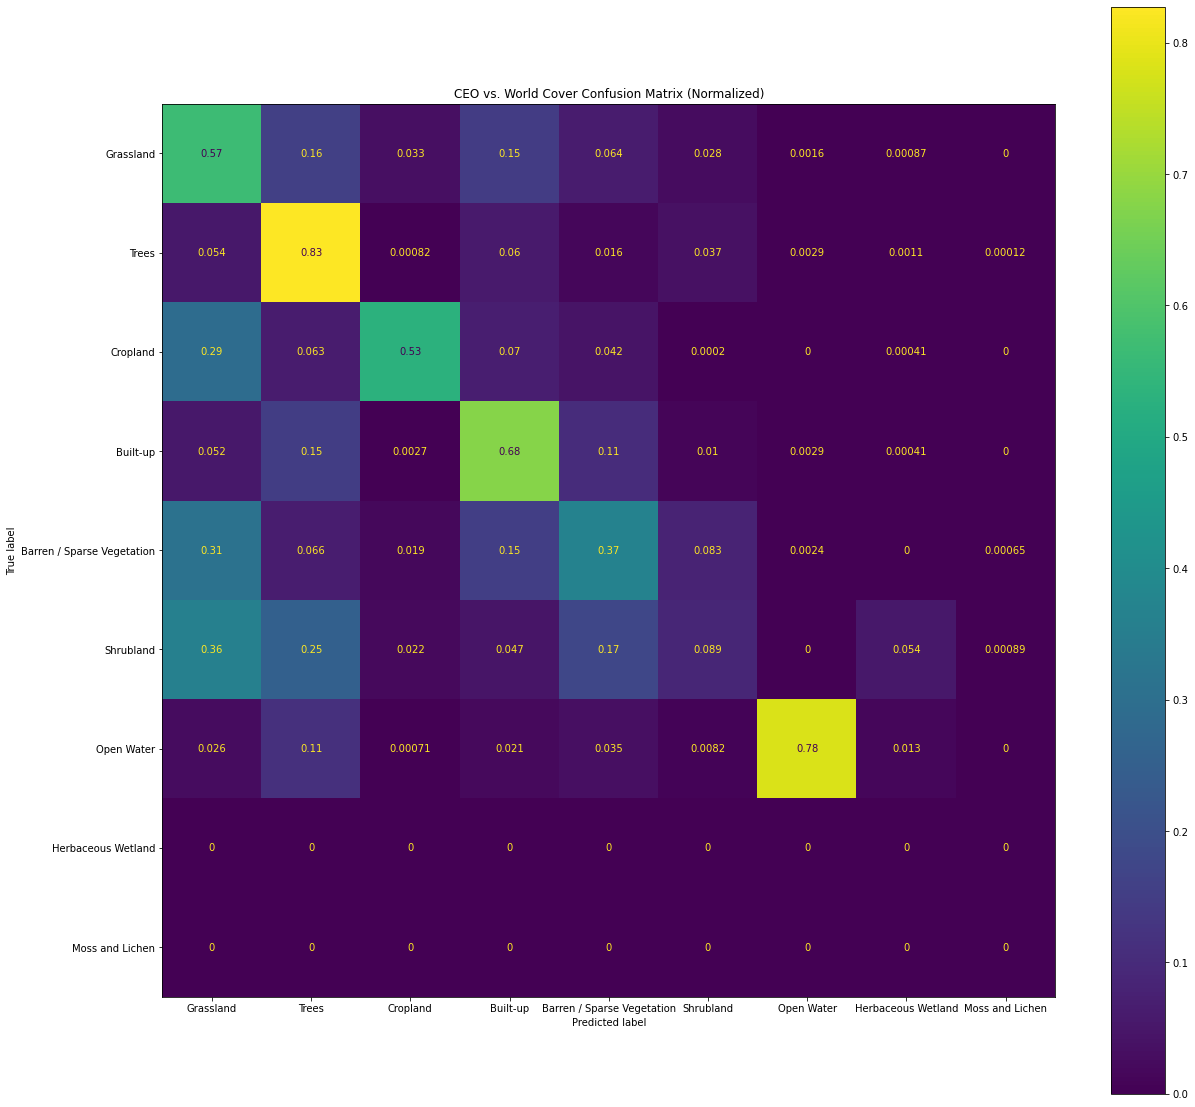

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("CEO vs. World Cover Confusion Matrix (Normalized)")
display_matrix = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=labels
)

display_matrix.plot(ax=ax)
plt.savefig("matrix.png")

## Accuracy and Correlation Statistics

In [20]:
cohen_kappa = cohen_kappa_score(wc_df["classification"], wc_df["WC_Class"])
accuracy = accuracy_score(wc_df["classification"], wc_df["WC_Class"])

In [21]:
cohen_kappa

0.5459239818457132

In [22]:
accuracy

0.6523520249221184

## Identification Distributions

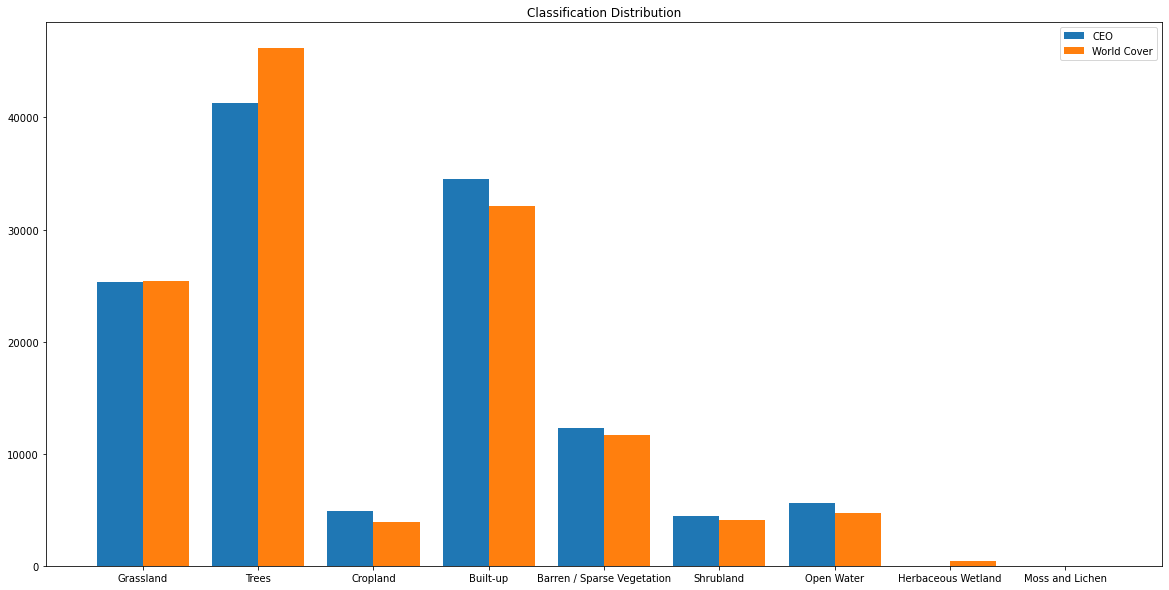

In [23]:
ceo_distribution = Counter(wc_df["classification"])
wc_distribution = Counter(wc_df["WC_Class"])

for key in wc_distribution.keys():
    if key not in ceo_distribution:
        ceo_distribution[key] = 0

combined = {
    classification: [ceo_distribution[classification], count]
    for classification, count in wc_distribution.items()
}
ceo_values = [combined[classification][0] for classification in combined.keys()]
wc_values = [combined[classification][1] for classification in combined.keys()]
plt.figure(figsize=(20, 10))

X = list(combined.keys())
x_axis = np.arange(len(X))
plt.xticks(x_axis, X)
plt.bar(x_axis - 0.2, ceo_values, 0.4, label="CEO")
plt.bar(x_axis + 0.2, wc_values, 0.4, label="World Cover")
plt.legend()
plt.title("Classification Distribution")
plt.show()

## Aggregated Plot Accuracy Summaries

In [24]:
plot_groups = wc_df.groupby("plotid")
plot_groups.apply(
    lambda data: accuracy_score(data["classification"], data["WC_Class"])
).describe()

count    1284.000000
mean        0.652352
std         0.279569
min         0.000000
25%         0.497500
50%         0.680000
75%         0.890000
max         1.000000
dtype: float64

# Map Visualization

## Setup

`aoi_number`: The aoi number that needs to be visualized

In [25]:
aoi_number = 10723

In [26]:
sentinel_image = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate("2020-01-01", "2020-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
    .map(sentinel_cloud_mask)
    .reduce(ee.Reducer.median())
)
folium.Map.add_ee_layer = add_ee_layer

## Generate Legend

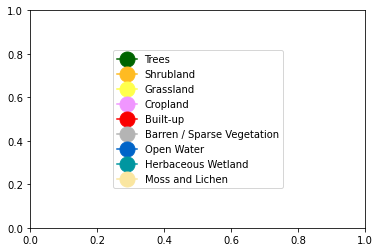

In [28]:
handles = [
    Line2D([0], [0], marker="o", color=color, label=label, markersize=15)
    for label, color in worldcover_legend.items()
]
labels = worldcover_legend.keys()


def export_legend(legend, filename="legend.png"):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)


fig, ax = plt.subplots()
ax.legend(handles=handles, loc="center")

plt.show()

## Interactive Visualization

In [29]:
def generate_aoi_grid(m, aoi_data):
    grid = folium.FeatureGroup(name="100m Grid")
    for _, row in aoi_data.iterrows():
        coords = row[["lat", "lon"]].tolist()
        latitude_const, longitude_const = get_latlon_constants(4.5, coords[0])
        color = worldcover_legend[row["Land Cover Elements"]]
        bounds = [
            [coords[0] - latitude_const, coords[1] - longitude_const],
            [coords[0] + latitude_const, coords[1] + longitude_const],
        ]
        folium.Rectangle(
            bounds=bounds,
            fill=True,
            color="#000000",
            fill_color=color,
            fill_opacity=0.75,
        ).add_to(grid)
    grid.add_to(m)


def get_aoi_coords(valid_data, aoi_number):
    aoi_data = valid_data[valid_data["plotid"] == aoi_number]
    map_lat, map_lon = aoi_data[["lat", "lon"]].iloc[int(len(aoi_data) / 2)].tolist()
    return map_lat, map_lon


def plot_aoi_map(m, valid_data, aoi_number):

    aoi_data = valid_data[valid_data["plotid"] == aoi_number]
    map_lat, map_lon = get_aoi_coords(valid_data, aoi_number)

    m.add_ee_layer(dataset, worldcover_visualization, "Worldcover Map")
    m.add_ee_layer(sentinel_image, sentinel_image_viz_params, "Sentinel Image")

    generate_aoi_grid(m, aoi_data)

    folium.LayerControl().add_to(m)
    print(f"Latitude: {map_lat}, Longitude: {map_lon}")

In [30]:
map_lat, map_lon = get_aoi_coords(valid_data, aoi_number)
m = folium.Map([map_lat, map_lon], zoom_start=20)
plot_aoi_map(m, valid_data, aoi_number)
display(m)

Latitude: 37.65573665659477, Longitude: -75.8243997181051


## Automated Screen Shotting of Map (Not supported on Colab)

In [31]:
screenshot_directory = "Folium Map Screenshots"
resolution = (720, 720)

In [32]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait


def resize(filename, resolution):
    img = Image.open(filename)
    img.resize(resolution).save(filename)


def screenshot(map_obj, outdirectory, filename, resolution):
    # Setup
    filename = f"{outdirectory}/{filename}.png"
    map_obj.save("map.html")
    driver = webdriver.Chrome(ChromeDriverManager().install())

    driver.set_window_size(720, 720)
    driver.get("file://{}".format(os.path.join(os.getcwd(), "map.html")))

    # Waits for map data to fully load
    wait = WebDriverWait(driver, 10)
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "leaflet-zoom-animated")))

    # Wait a little longer for map to render
    time.sleep(1)

    # Teardown
    driver.save_screenshot(filename)
    driver.close()
    resize(filename, resolution)
    os.remove("map.html")


def get_screenshots(aoi_number, outdirectory, resolution):
    if not os.path.exists(outdirectory):
        os.makedirs(outdirectory)
    map_lat, map_lon = get_aoi_coords(valid_data, aoi_number)
    m = folium.Map([map_lat, map_lon], zoom_start=20)
    plot_aoi_map(m, valid_data, aoi_number)
    screenshot(m, outdirectory, f"wc_ceo_{aoi_number}", resolution)

    m = folium.Map([map_lat, map_lon], zoom_start=20)
    m.add_ee_layer(dataset, worldcover_visualization, "Worldcover Map")
    folium.LayerControl().add_to(m)
    screenshot(m, outdirectory, f"wc_{aoi_number}", resolution)

    m = folium.Map([map_lat, map_lon], zoom_start=20)
    m.add_ee_layer(sentinel_image, sentinel_image_viz_params, "Sentinel Image")
    folium.LayerControl().add_to(m)
    screenshot(m, outdirectory, f"sentinel_{aoi_number}", resolution)

In [33]:
get_screenshots(aoi_number, screenshot_directory, resolution)



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome


Latitude: 37.65573665659477, Longitude: -75.8243997181051


Driver [C:\Users\piphi\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\piphi\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\piphi\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache
